# Space Shuttle Reentry Trajectory

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__))
Pkg.instantiate()

 Activating environment at `~/git/space-shuttle-reentry-trajectory/Project.toml`


In [2]:
using Interpolations
using KNITRO
using Plots
using SparseArrays
using SparseDiffTools
using SparsityDetection

In [3]:
# Global variables
const w  = 203000  # weight (lb)
const g₀ = 32.174  # acceleration (ft/sec^2)
const m  = w / g₀  # mass (slug)

# Aerodynamic and atmospheric forces on the vehicle
const ρ₀ =  0.002378
const hᵣ =  23800
const Rₑ =  20902900
const μ  =  0.14076539e17
const S  =  2690
const a₀ = -0.20704
const a₁ =  0.029244
const b₀ =  0.07854
const b₁ = -0.61592e-2
const b₂ =  0.621408e-3
const c₀ =  1.0672181
const c₁ = -0.19213774e-1
const c₂ =  0.21286289e-3
const c₃ = -0.10117249e-5

â(a) = 180 * a / π

c_L(a) = a₀ + a₁ * â(a)
c_D(a) = b₀ + b₁ * â(a) + b₂ * â(a)^2

D(h, v, a) = 0.5 * c_D(a) * S * ρ(h) * v^2
L(h, v, a) = 0.5 * c_L(a) * S * ρ(h) * v^2

r(h) = Rₑ + h
g(h) = μ / r(h)^2
ρ(h) = ρ₀ * exp(-h / hᵣ)

# Aerodynamic heating on the vehicle wing leading edge
qₐ(a) = c₀ + c₁ * â(a) + c₂ * â(a)^2 + c₃ * â(a)^3
qᵣ(h, v) = 17700 * √ρ(h) * (0.0001 * v)^3.07
q(h, v, a) = qₐ(a) * qᵣ(h, v)

# Motion of the vehicle as a differential-algebraic system of equations (DAEs)
δh(v, γ) = v * sin(γ)
δϕ(h, θ, v, γ, ψ) = (v / r(h)) * cos(γ) * sin(ψ) / cos(θ)
δθ(h, v, γ, ψ) = (v / r(h)) * cos(γ) * cos(ψ)
δv(h, v, γ, α) = -(D(h, v, α) / m) - g(h) * sin(γ)
δγ(h, v, γ, α, β) = (L(h, v, α) / (m * v)) * cos(β) + cos(γ) * ((v / r(h)) - (g(h) / v))
δψ(h, θ, v, γ, ψ, α, β) = (1 / (m * v * cos(γ))) * L(h, v, α) * sin(β) + (v / (r(h) * cos(θ))) * cos(γ) * sin(ψ) * sin(θ)

# Initial conditions
hₛ = 2.6          # altitude (ft) / 1e5
ϕₛ = deg2rad(0)   # longitude (rad)
θₛ = deg2rad(0)   # latitude (rad)
vₛ = 2.56         # velocity (ft/sec) / 1e4
γₛ = deg2rad(-1)  # flight path angle (rad)
ψₛ = deg2rad(90)  # azimuth (rad)
αₛ = deg2rad(0)   # angle of attack (rad)
βₛ = deg2rad(0)   # banck angle (rad)
tₛ = 1.00         # time step (sec)

# Final conditions, the so-called Terminal Area Energy Management (TAEM)
hₜ = 0.8          # altitude (ft) / 1e5
vₜ = 0.25         # velocity (ft/sec) / 1e4
γₜ = deg2rad(-5)  # flight path angle (rad)

xₛ = [hₛ, ϕₛ, θₛ, vₛ, γₛ, ψₛ, αₛ, βₛ, tₛ]
xₜ = [hₜ, ϕₛ, θₛ, vₜ, γₜ, ψₛ, αₛ, βₛ, tₛ]

@show xₛ xₜ;

xₛ = [2.6, 0.0, 0.0, 2.56, -0.017453292519943295, 1.5707963267948966, 0.0, 0.0, 1.0]
xₜ = [0.8, 0.0, 0.0, 0.25, -0.08726646259971647, 1.5707963267948966, 0.0, 0.0, 1.0]


## Direct Transcription Formulation

In [4]:
N = 2008  # number of segments
M = N + 1  # number of mesh points

# Linear initial guess between the boundary conditions
interp_linear = LinearInterpolation([1, M], [xₛ, xₜ])
seed = [value for x = 1:M for value in interp_linear(x)]

nₓ = length(xₛ)  # mesh points dimension
n = nₓ * M  # number of decision variables
@assert n == length(seed)

ind_h = 1:nₓ:n  # indices of the `h` decision variables
ind_ϕ = 2:nₓ:n  # indices of the `ϕ` decision variables
ind_θ = 3:nₓ:n  # indices of the `θ` decision variables
ind_v = 4:nₓ:n  # indices of the `v` decision variables
ind_γ = 5:nₓ:n  # indices of the `γ` decision variables
ind_ψ = 6:nₓ:n  # indices of the `ψ` decision variables
ind_α = 7:nₓ:n  # indices of the `α` decision variables
ind_β = 8:nₓ:n  # indices of the `β` decision variables
ind_t = 9:nₓ:n  # indices of the `t` decision variables
@assert length(ind_h) == length(ind_v) == length(ind_α) == M

m_dyn = 6 * N
ind_con_dyn = 1:m_dyn  # indices of the dynamics' constraints (defects)
@assert length(ind_con_dyn) == 6 * (M - 1)

### Forward dynamics and constraint callbacks

In [5]:
EulerStep(x, δx, h) = x + h*δx

function dynamics_defects!(dx, x)
    hᵢ, ϕᵢ, θᵢ, vᵢ, γᵢ, ψᵢ, αᵢ, βᵢ, tᵢ, hⱼ, ϕⱼ, θⱼ, vⱼ, γⱼ, ψⱼ = x

    # Unit correction due to decision variable scaling
    hᵢ *= 1e5; hⱼ *= 1e5; vᵢ *= 1e4; vⱼ *= 1e4

    dx[1] = EulerStep(hᵢ, δh(        vᵢ, γᵢ            ), tᵢ) - hⱼ
    dx[2] = EulerStep(ϕᵢ, δϕ(hᵢ, θᵢ, vᵢ, γᵢ, ψᵢ        ), tᵢ) - ϕⱼ
    dx[3] = EulerStep(θᵢ, δθ(hᵢ,     vᵢ, γᵢ, ψᵢ        ), tᵢ) - θⱼ
    dx[4] = EulerStep(vᵢ, δv(hᵢ,     vᵢ, γᵢ,     αᵢ    ), tᵢ) - vⱼ
    dx[5] = EulerStep(γᵢ, δγ(hᵢ,     vᵢ, γᵢ,     αᵢ, βᵢ), tᵢ) - γⱼ
    dx[6] = EulerStep(ψᵢ, δψ(hᵢ, θᵢ, vᵢ, γᵢ, ψᵢ, αᵢ, βᵢ), tᵢ) - ψⱼ

    return nothing
end

function cb_eval_fc_con_dyn(kc, cb, evalRequest, evalResult, userParams)
    x = evalRequest.x

    for i = 0:M - 2
        ind_xᵢ = (1:nₓ) .+ i * nₓ
        ind_xⱼ = ind_xᵢ .+ nₓ
        ind_con = (1:6) .+ i * 6

        xᵢ = x[ind_xᵢ][1:9]
        xⱼ = x[ind_xⱼ][1:6]

        @views dynamics_defects!(evalResult.c[ind_con], [xᵢ; xⱼ])
    end

    return 0
end

function cb_eval_ga_con_dyn(kc, cb, evalRequest, evalResult, userParams)
    x = evalRequest.x

    for i = 0:M - 2
        ind_xᵢ = (1:nₓ) .+ i * nₓ
        ind_xⱼ = ind_xᵢ .+ nₓ
        ind_con = (1:6) .+ i * 6

        xᵢ = x[ind_xᵢ][1:9]
        xⱼ = x[ind_xⱼ][1:6]

        forwarddiff_color_jacobian!(jac_dyn, dynamics_defects!, [xᵢ; xⱼ], jac_cache)

        aux_jac = i * length_jac
        ind_jac = aux_jac + 1 : aux_jac + length_jac
        evalResult.jac[ind_jac] = nonzeros(jac_dyn)
    end

    return 0
end;

In [6]:
input = rand(15)
output = zeros(6)
sparsity_pattern = jacobian_sparsity(dynamics_defects!, output, input)
jac_dyn = Float64.(sparse(sparsity_pattern))
length_jac = nnz(jac_dyn)

jac_cache = ForwardColorJacCache(dynamics_defects!, input, dx = output,
                                 colorvec = matrix_colors(jac_dyn),
                                 sparsity = sparsity_pattern)

forwarddiff_color_jacobian!(jac_dyn, dynamics_defects!, input, jac_cache)

jacIndexConsCB = Cint.(hcat([rowvals(jac_dyn) .+ i*6 for i = 0:N-1]...) .- 1)
jacIndexVarsCB = Cint.(hcat([vcat([fill(j + i*nₓ, length(nzrange(jac_dyn, j))) for j = 1:15]...) for i = 0:N-1]...) .- 1);

Explored path: SparsityDetection.Path(Bool[], 1)


### Optimization

In [6]:
lm = KNITRO.LMcontext()
kc = KNITRO.KN_new_lm(lm)

KNITRO.KN_add_vars(kc, n)

!isempty(seed) && KNITRO.KN_set_var_primal_init_values(kc, seed)

KNITRO.KN_set_var_lobnds(kc, collect(Cint, ind_h .- 1), zeros(M))  # `h` bounds
KNITRO.KN_set_var_lobnds(kc, collect(Cint, ind_v .- 1), fill(1 / 1e4, M))  # `v` bounds

KNITRO.KN_set_var_lobnds(kc, collect(Cint, ind_θ .- 1), fill(deg2rad(-89), M))  # `θ` lower bounds
KNITRO.KN_set_var_upbnds(kc, collect(Cint, ind_θ .- 1), fill(deg2rad( 89), M))  # `θ` upper bounds

KNITRO.KN_set_var_lobnds(kc, collect(Cint, ind_γ .- 1), fill(deg2rad(-89), M))  # `γ` lower bounds
KNITRO.KN_set_var_upbnds(kc, collect(Cint, ind_γ .- 1), fill(deg2rad( 89), M))  # `γ` upper bounds

KNITRO.KN_set_var_lobnds(kc, collect(Cint, ind_α .- 1), fill(deg2rad(-90), M))  # `α` lower bounds
KNITRO.KN_set_var_upbnds(kc, collect(Cint, ind_α .- 1), fill(deg2rad( 90), M))  # `α` upper bounds

KNITRO.KN_set_var_lobnds(kc, collect(Cint, ind_β .- 1), fill(deg2rad(-89), M))  # `β` lower bounds
KNITRO.KN_set_var_upbnds(kc, collect(Cint, ind_β .- 1), fill(deg2rad(  1), M))  # `β` upper bounds

# KNITRO.KN_set_var_lobnds(kc, collect(Cint, ind_t .- 1), zeros(M))  # `t` lower bounds
KNITRO.KN_set_var_fxbnds(kc, collect(Cint, ind_t .- 1), fill(1.00, M))  # Fix time steps

# Fix initial and final conditions
ind_fixed_vars = [ind_h[1]:ind_ψ[1] ; [ind_h[end], ind_v[end], ind_γ[end]]]
val_fixed_vars = [hₛ, ϕₛ, θₛ, vₛ, γₛ, ψₛ, hₜ, vₜ, γₜ]
KNITRO.KN_set_var_fxbnds(kc, collect(Cint, ind_fixed_vars .- 1), val_fixed_vars)

KNITRO.KN_add_cons(kc, m_dyn)

KNITRO.KN_set_con_eqbnds(kc, collect(Cint, ind_con_dyn .- 1), zeros(m_dyn))  # defects

cb_dyn = KNITRO.KN_add_eval_callback(kc, false, collect(Cint, ind_con_dyn .- 1), cb_eval_fc_con_dyn)

KNITRO.KN_set_cb_grad(kc, cb_dyn, cb_eval_ga_con_dyn,
                      nV = 0, objGradIndexVars = C_NULL,
                      jacIndexCons = jacIndexConsCB,
                      jacIndexVars = jacIndexVarsCB)

# Add objective.
objIndex, objCoef = ind_θ[end], 1.0
KNITRO.KN_add_obj_linear_struct(kc, objIndex - 1, objCoef)
KNITRO.KN_set_obj_goal(kc, KNITRO.KN_OBJGOAL_MAXIMIZE)

KNITRO.KN_set_newpt_callback(kc, (kc, x, duals, userParams) -> (print(""); return 0))

KNITRO.KN_set_param(kc, KNITRO.KN_PARAM_ALG,        KNITRO.KN_ALG_BAR_DIRECT)
KNITRO.KN_set_param(kc, KNITRO.KN_PARAM_BAR_MURULE, KNITRO.KN_BAR_MURULE_PROBING)
KNITRO.KN_set_param(kc, KNITRO.KN_PARAM_LINSOLVER,  KNITRO.KN_LINSOLVER_MA27)
KNITRO.KN_set_param(kc, KNITRO.KN_PARAM_HESSOPT,    KNITRO.KN_HESSOPT_LBFGS)
KNITRO.KN_set_param(kc, KNITRO.KN_PARAM_MAXTIMECPU, 20.0)  # Default: 1.0e8

KNITRO.KN_solve(kc)
nStatus, objSol, x, lambda_ = KNITRO.KN_get_solution(kc)
cpu_time = KNITRO.KN_get_solve_time_real(kc)

KNITRO.KN_free(kc)
KNITRO.KN_release_license(lm)

print("Final latitude θ = $(round(rad2deg(x[ind_θ[end]]), digits = 2))°")


           Academic License
       (NOT FOR COMMERCIAL USE)
         Artelys Knitro 12.1.0

Knitro presolve eliminated 2018 variables and 0 constraints.

algorithm:               1
bar_murule:              3
hessopt:                 6
linsolver:               4
maxtime_cpu:             20
Knitro changing bar_initpt from AUTO to 3.
Knitro changing bar_penaltycons from AUTO to 0.
Knitro changing bar_penaltyrule from AUTO to 2.
Knitro changing bar_switchrule from AUTO to 2.
Knitro changing linesearch from AUTO to 1.
Knitro fixing 2018 variables eliminated from the presolve.

Problem Characteristics                                 (   Presolved)
-----------------------
Objective goal:  Maximize
Objective type:  linear
Number of variables:                              18081 (       16063)
    bounded below only:                            4014 (        4014)
    bounded above only:                               0 (           0)
    bounded below and above:                       8033 (     

## Results

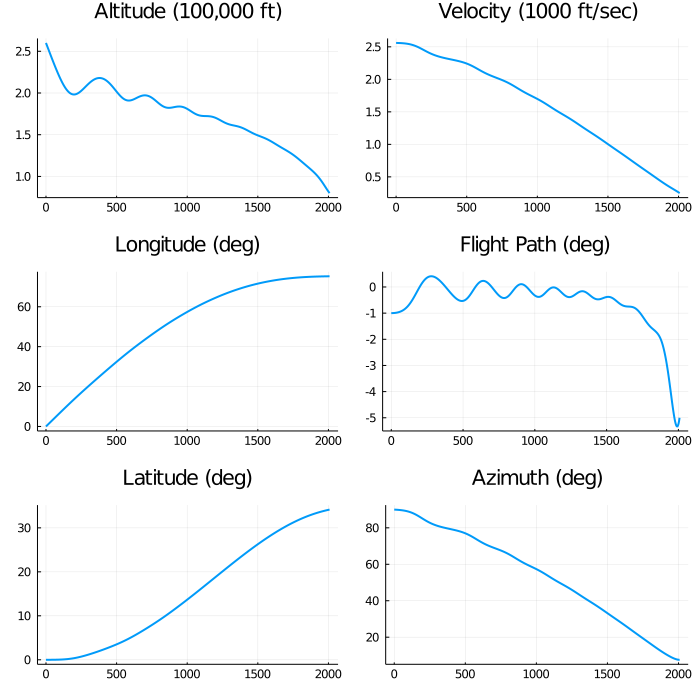

In [7]:
ts = cumsum([0 ; x[ind_t][1:end-1]])

plt_altitude = plot(ts, x[ind_h], legend = nothing, title = "Altitude (100,000 ft)")
plt_longitude = plot(ts, rad2deg.(x[ind_ϕ]), legend = nothing, title = "Longitude (deg)")
plt_latitude = plot(ts, rad2deg.(x[ind_θ]), legend = nothing, title = "Latitude (deg)")
plt_velocity = plot(ts, x[ind_v], legend = nothing, title = "Velocity (1000 ft/sec)")
plt_flight_path = plot(ts, rad2deg.(x[ind_γ]), legend = nothing, title = "Flight Path (deg)")
plt_azimuth = plot(ts, rad2deg.(x[ind_ψ]), legend = nothing, title = "Azimuth (deg)")

plt = plot(plt_altitude,  plt_velocity, plt_longitude, plt_flight_path, plt_latitude,
           plt_azimuth, layout = grid(3, 2), linewidth = 2, size = (700, 700))

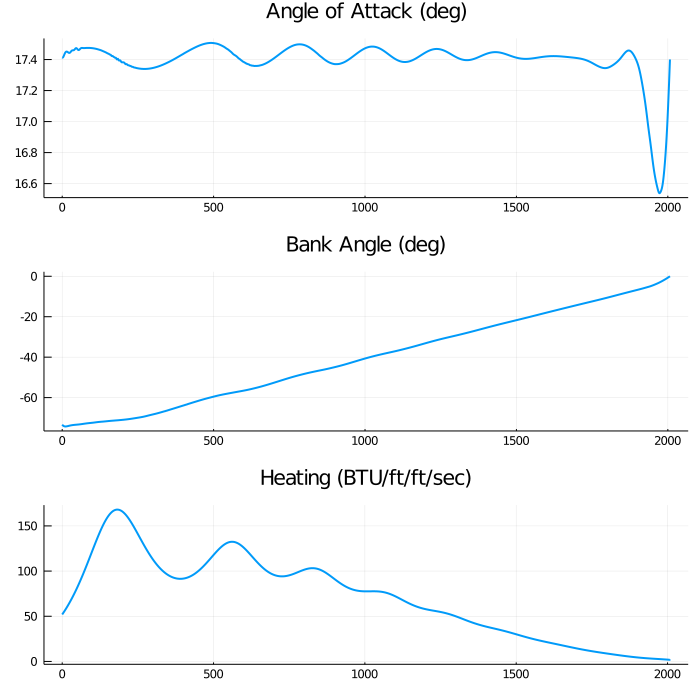

In [8]:
plt_attack_angle = plot(ts[1:end-1], rad2deg.(x[ind_α][1:end-1]), legend = nothing, title = "Angle of Attack (deg)")
plt_bank_angle = plot(ts[1:end-1], rad2deg.(x[ind_β][1:end-1]), legend = nothing, title = "Bank Angle (deg)")
plt_heating = plot(ts, q.(x[ind_h]*1e5, x[ind_v]*1e4, x[ind_α]), legend = nothing, title = "Heating (BTU/ft/ft/sec)") 

plt = plot(plt_attack_angle, plt_bank_angle, plt_heating, layout = grid(3, 1), linewidth = 2, size = (700, 700))

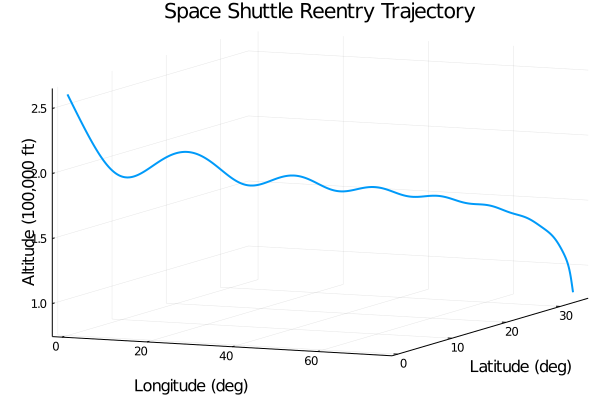

In [9]:
plt = plot(rad2deg.(x[ind_ϕ]), rad2deg.(x[ind_θ]), x[ind_h], linewidth = 2,
           legend = nothing, title = "Space Shuttle Reentry Trajectory",
           xlabel = "Longitude (deg)", ylabel = "Latitude (deg)", zlabel = "Altitude (100,000 ft)")